In [1]:
chan_index = int(input('Enter channel index to analyze:'))
# print('Enter Open Ephys data directory path:')
# source_path = raw_input()

Enter channel index to analyze:2


In [2]:
source_path = '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/'

In [3]:
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
f_names = []
for root, dirnames, filenames in os.walk(source_path):
    for filename in filenames:
        f_regex = re.compile(r".*CH(\d|\d\d)\.continuous$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]
f_names = np.array(f_names)
chans = [int(f.split('.')[-2].split('_')[-1][2:]) for f in f_names]
f_names = f_names[np.argsort(chans)] # now sorted by channel number

In [6]:
f_names

array(['../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH1.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH2.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH3.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH4.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH5.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH6.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH7.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH8.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH9.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH10.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH11.continuous',
       '../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH12.continuous',
 

In [ ]:
chan_data = []
for contact in range(7):
    contact_reps = []
    for i in range(contact*4, contact*4 + 4):
        print('Reading {}...'.format(f_names[i]))
        file_content = OpenEphys.load(f_names[i])
        Fs = float(file_content['header']['sampleRate'])
        signal_filtered = butter_bandpass_filter(file_content['data'], 300, 30000, Fs, order=2 )
        contact_reps.append(signal_filtered)
    contact_reps = np.array(contact_reps)
    chan_data.append(np.mean(contact_reps, axis=0))
    print('-----------------------------------------------')
chan_data = np.array(chan_data)
contact_reps = None

In [29]:
f_names.size

53

In [65]:
file_content = OpenEphys.load(f_names[0])
Fs = float(file_content['header']['sampleRate'])
mean_signal = butter_bandpass_filter(file_content['data'], 200, 10000, Fs, order=2 )

for contact in range(1, 32):
    contact_reps = []
    file_content = OpenEphys.load(f_names[contact])
    Fs = float(file_content['header']['sampleRate'])
    signal_filtered = butter_bandpass_filter(file_content['data'], 200, 10000, Fs, order=2 )
    mean_signal = np.add(mean_signal, signal_filtered)
    print('-----------------------------------------------')
mean_signal = mean_signal/32

Loading continuous data...
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
-----------------------------------------------
Loading continuous data...
----------------------------------------------

In [66]:
print('Reading file {} ...'.format(f_names[chan_index]))
file_content = OpenEphys.load(f_names[chan_index])
Fs = float(file_content['header']['sampleRate'])
chan_data = butter_bandpass_filter(file_content['data'], 200, 10000, Fs, order=2 )
chan_data = np.subtract(chan_data, mean_signal)
chan_data = scipy.signal.detrend(chan_data)
chan_filtered_fname = os.path.join(source_path, 'CH{}_filtered.npy'.format(chan_index+1))
print('Saving filtered data to {}'.format(chan_filtered_fname))
np.save(chan_filtered_fname, chan_data)

Reading file ../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/100_CH3.continuous ...
Loading continuous data...
Saving filtered data to ../data/OpenEphys_data/2019-08-09/2019-08-09_16-20-45/CH3_filtered.npy


In [41]:
chan_data.size


72036352

In [40]:
chan_filtered_fname = os.path.join(source_path, 'CH{}_filtered.npy'.format(chan_index+1))
chan_data = np.load(chan_filtered_fname)
Fs = 30000.0

In [41]:
chan_data = butter_bandpass_filter(chan_data, 0.01, 5000, Fs, order=2 )


In [73]:
chan_data[29877690: 29877840] = chan_data[29877690]

### Plot channel voltage

<IPython.core.display.Javascript object>


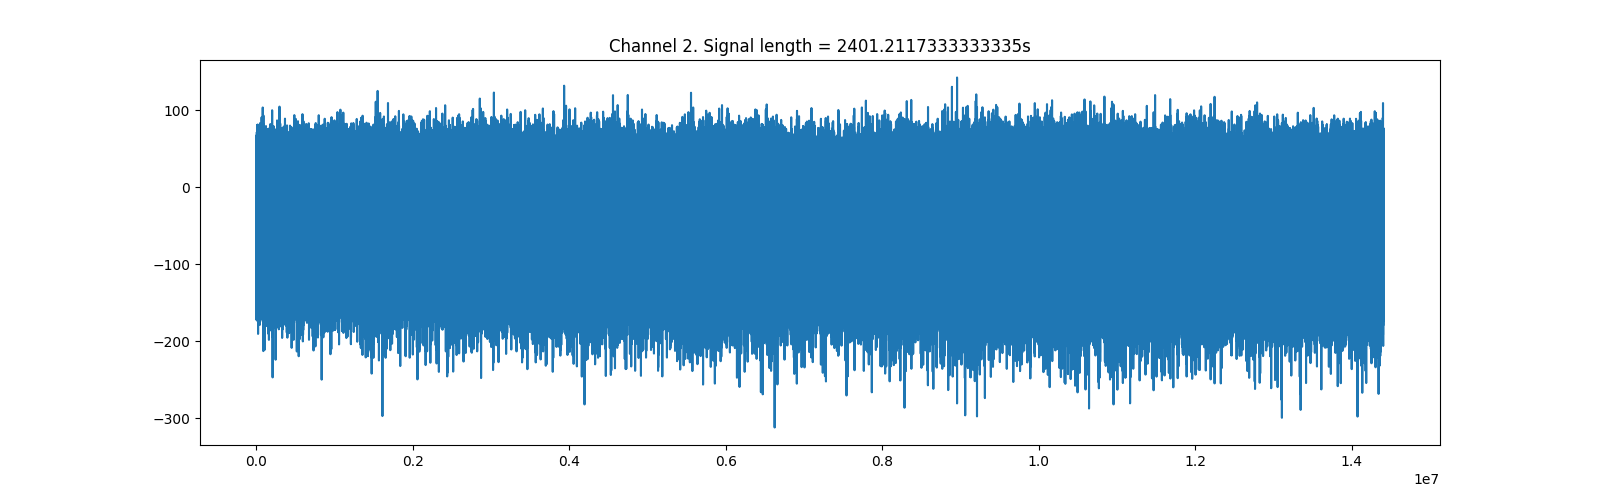

Text(0.5, 1.0, 'Channel 2. Signal length = 2401.2117333333335s')

In [75]:
# plot channel
plt.figure(figsize=(16,5))
plt.plot(chan_data[::5])
plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.size/Fs))

In [76]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data, dt)
css.num_gmm_components = 5
css.cs_num_gmm_components = 15
css.pre_window = 0.0001
css.post_window = 0.0025
css.run(use_filtered=False, remove_overlap=False, spike_detection_dir = 'min', align_spikes_to='min')

Pre-process...
Using minibatch spike detection, batch size = 50s, using filter (derivative) is False
Using spikes min for detection. Aligning them to their min. 
Spike detection time = 85.73287177085876
Using all spikes for alignment (no overlap removal)
Align spikes time = 0.5050859451293945
Clustering complex spikes...
Splitting detected spikes for CS clustering ...
CS spike detection time = 83.56376314163208
Merging overlapping CS waveforms
CS post process time = 0.007821321487426758


In [78]:
css.cs_indices.shape

(3338,)

In [79]:
num_clusters = 12
pre_time = 0.0005
post_time = 0.0025
clusters, cluster_labels = css.cluster_detected_cs(num_clusters=num_clusters, pre_time=pre_time, post_time=post_time)
ss_indices = css.get_ss_indices()

In [80]:
ss_indices.shape

(177039,)

In [81]:
import random
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)

In [82]:
t1 = time.time()
print('Total run time = {} s'.format(t1-t0))

Total run time = 87939.86178016663 s


<IPython.core.display.Javascript object>


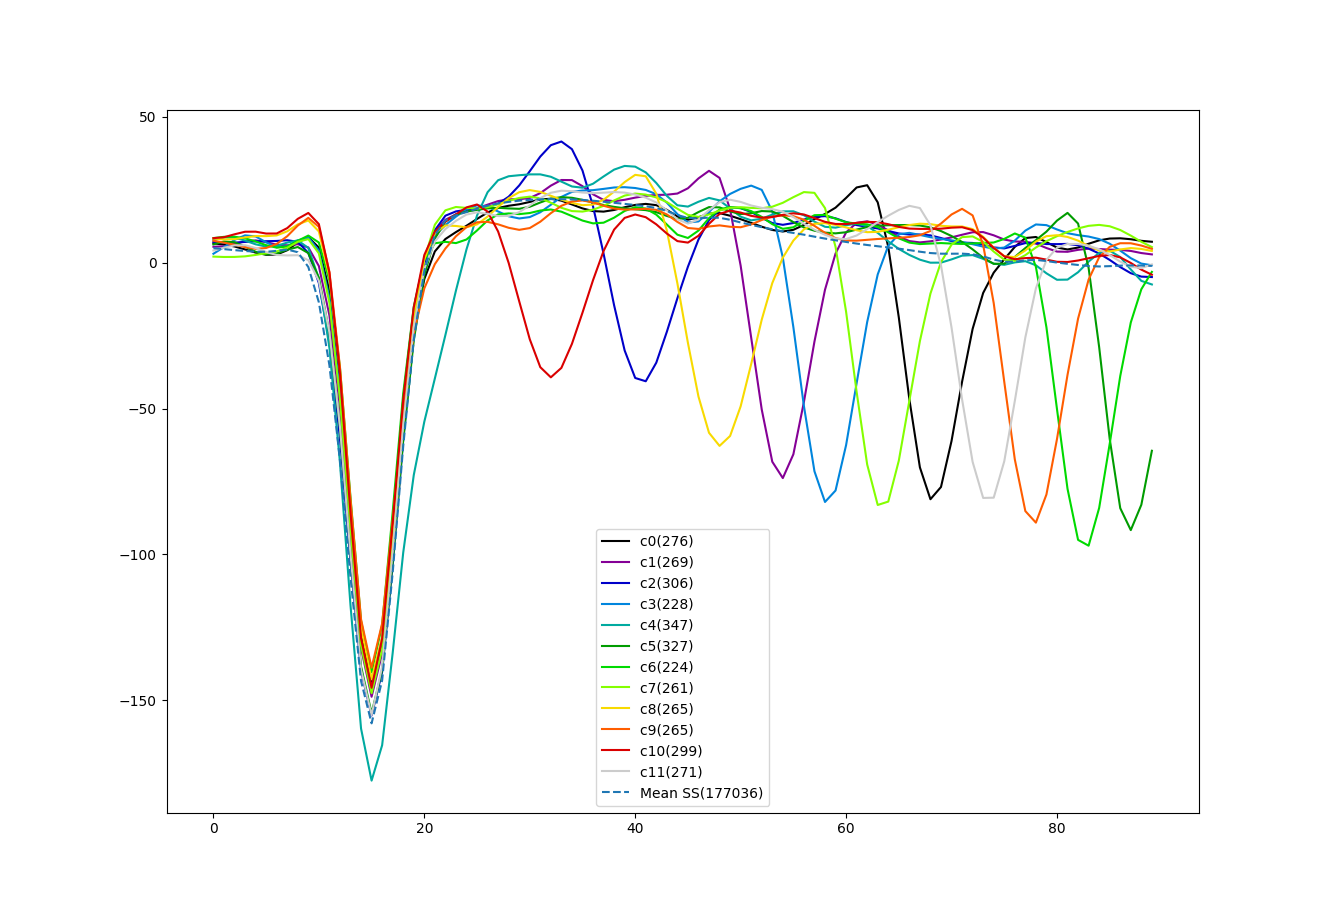

In [83]:
# plot cluster means
colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(8,5))
clust_means = []
paxes = []
for cn in np.arange(num_clusters):
    clust_means.append(np.mean(clusters[cn], axis=0))
    ax = plt.plot(clust_means[-1], color = colors[cn], label = legend_labels[cn])
    paxes.append(ax)
plt.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
plt.legend() 

In [84]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(clust_means)
cs_clust = np.argmax(np.sum(np.abs(kmeans.cluster_centers_), axis=1))
clusters_to_pick = np.where(kmeans.labels_ == cs_clust)[0]
print('Detected CS clusters: {}'.format(clusters_to_pick))

Detected CS clusters: [1 3 7]


In [92]:
ans = input("Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: ")
ans_regex = re.compile(r'\d+(?:,\d+)?')
if ans_regex.match(ans):
    clusters_to_pick = [int(c) for c in ans.split(',')]
    

Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: 2


In [93]:
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))

Number of detected CS: (306,)


<IPython.core.display.Javascript object>


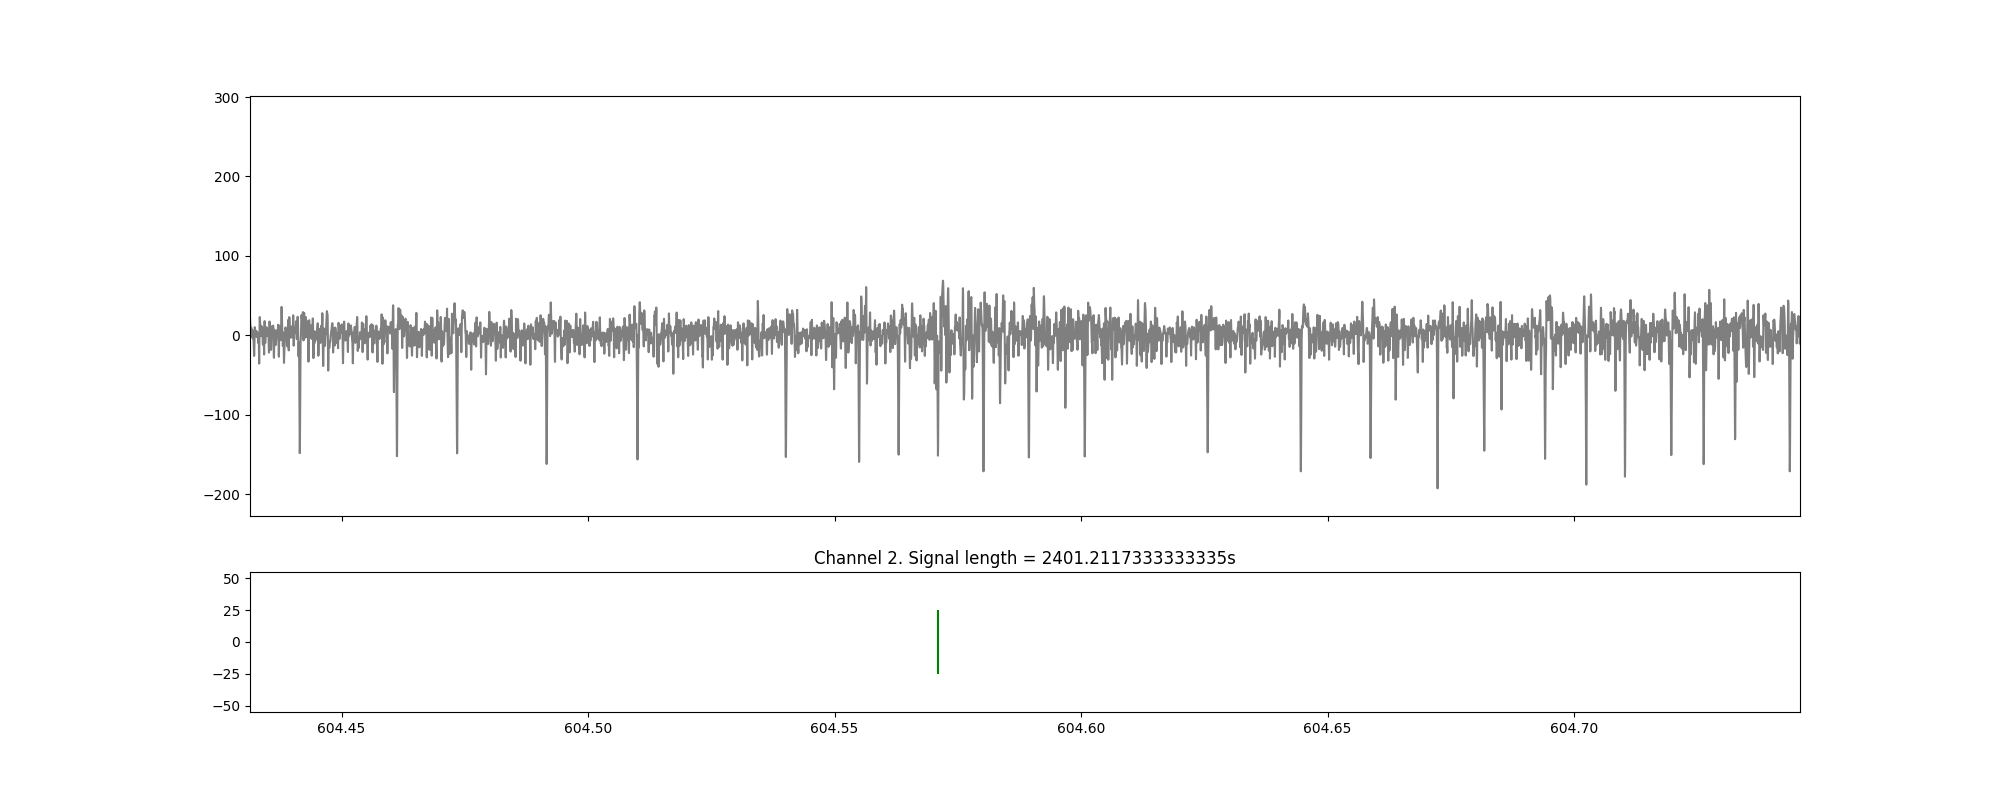

Text(0.5, 1.0, 'Channel 2. Signal length = 2401.2117333333335s')

In [98]:
# plot channel
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,8), sharex=True)

# prange = [css.signal_size*css.dt - 100, css.signal_size*css.dt] #s
prange = [600,700] #s
idx_voltage = [int(pr*Fs) for pr in prange]
ax0.plot(np.arange(prange[0],prange[1],1/Fs), chan_data[idx_voltage[0]: idx_voltage[1]], alpha=0.5, color='k')
ax1.eventplot(css.cs_indices[np.where(np.logical_and(css.cs_indices < idx_voltage[1] , css.cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=0, color='g')
# ax1.eventplot(cs_indices[np.where(np.logical_and(cs_indices < idx_voltage[1] , cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=50, color='r')
# ax1.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices < idx_voltage[1] , css.spike_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=100, color='m')
# plt.plot(chan_data[chan_index,::10])
plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.size/Fs))

<IPython.core.display.Javascript object>


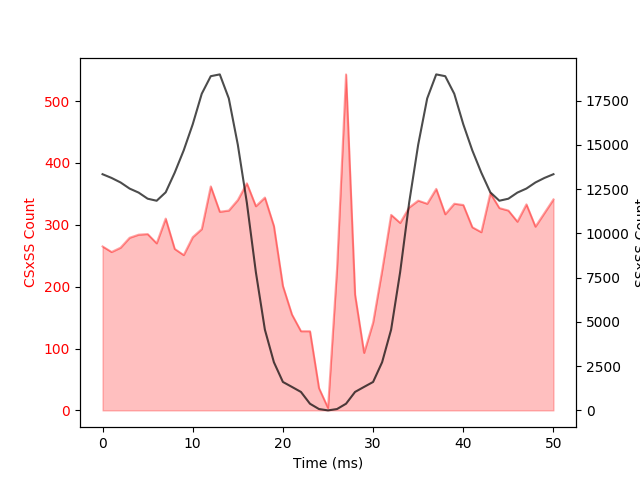

Text(0, 0.5, 'SSxSS Count')

In [99]:
SS = np.zeros(np.int64(css.signal_size/30.0))
SS[np.int64(ss_indices/30.0)] = 1
CS = np.zeros(np.int64(css.signal_size/30.0))
CS[np.int64(cs_indices/30.0)] = 1


window = 25
xcor_vect = np.zeros((2*window + 1))
for cti in np.int64(css.cs_indices[:-1]/30.0):
    xcor_vect = xcor_vect + SS[cti-window : cti + window + 1]

window = 25
acor_vect = np.zeros((2*window + 1))
for sti in np.int64(ss_indices[10:-10]/30.0):
    acor_vect = acor_vect + SS[sti-window : sti + window + 1]

acor_vect[25] = 0

plt.figure()
plt.plot(xcor_vect, 'r', alpha=0.35)
plt.yticks(color='r')
plt.fill_between(np.arange(0,2*window + 1), xcor_vect, color='r', alpha=0.25)
plt.ylabel('CSxSS Count', color = 'r')
plt.xlabel('Time (ms)')

plt.twinx()
plt.plot(acor_vect, 'k', alpha=0.70)
plt.yticks(color='k')
plt.ylabel('SSxSS Count', color='k')
# plt.fill_between(acor_ret[0], 0, acor_ret[1] , color='g', alpha=0.25)


In [72]:
idx_voltage

[29877690, 29877840]

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(clust_means)
cs_clust = np.argmax(np.sum(np.abs(kmeans.cluster_centers_), axis=1))
clusters_to_pick = np.where(kmeans.labels_ == cs_clust)[0]
print('Detected CS clusters: {}'.format(clusters_to_pick))

In [ ]:
ans = input("Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: ")
ans_regex = re.compile(r'\d+(?:,\d+)?')
if ans_regex.match(ans):
    clusters_to_pick = [int(c) for c in ans.split(',')]
    

In [ ]:
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))

## Saving detected CS and SS:

In [ ]:
CS_csv_filename = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
SS_csv_filename = os.path.join(source_path, 'channel_{}.SS.csv'.format(chan_index))

import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(chan_data_raw[chan_index,:], alpha = 0.5)
plt.plot(chan_data[chan_index,:], alpha = 0.8)
plt.eventplot(cs_indices, linelengths=300, colors='r', alpha=0.4)
